Let's look at the effect of sweeping over the slider, and the scale

In [1]:
from activation_patching_toolkit import *
from typing import Union

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [3]:
def plot_pt_heatmap(
    heat: np.ndarray,
    scale: str = "linear",
    cmap: str = "viridis",
    vmin: float = None,
    vmax: float = None,
    save_path: str = None
):
    """
    Display a heatmap with either linear or logarithmic color scaling.

    Args:
      heat      : numpy array of the heatmap
      scale     : "linear" or "log"
      cmap      : any matplotlib colormap name
      vmin,vmax : manual color-range bounds (defaults to data min/max)
      save_path : if given, the figure is saved here (e.g. "hm.png")
    """
    # — build normalization object —
    norm = None
    if scale.lower() == "log":
        # avoid zeros
        nonzero = heat[heat > 0]
        vmin_ = vmin if vmin is not None else nonzero.min()
        vmax_ = vmax if vmax is not None else heat.max()
        norm = LogNorm(vmin=vmin_, vmax=vmax_)

    # — plot —
    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        heat,
        aspect="auto",
        origin="lower",
        norm=norm,
        vmin=None if norm else vmin,
        vmax=None if norm else vmax,
        cmap=cmap
    )
    cb = plt.colorbar(im, pad=0.02)
    cb.set_label(f"Value ({scale} scale)")
    plt.xlabel("Head index")
    plt.ylabel("Layer index")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved heatmap plot to {save_path}")

    plt.show()

load the slider data 

here, we varied between patching z outputs from the answer head, and the think head 

In [8]:
prompt_patched_generation_dict = load_pickle("/root/mech_interp_research/may_11_patch_sweep_pkls/prompt_patched_generation_dict.pkl")

In [52]:
import re
import matplotlib.pyplot as plt

def plot_each_prompt_behavior(data):
    """
    Normalizes think-region lengths per prompt and overlays each prompt's curve.
    If a prompt's baseline (scale=1.0) think-length is zero, all its normalized
    values are set to zero to avoid division by zero.
    
    Parameters:
        data (dict): Mapping (prompt, scale) -> generation string
    """
    # 1) Compute raw think-region lengths
    think_lengths = {}
    for (prompt, scale), gen in data.items():
        match = re.search(r"<think>(.*?)</think>", gen, re.DOTALL)
        length = len(model.to_tokens(match.group(1))[0]) if match else 0
        think_lengths.setdefault(prompt, {})[scale] = length

    # 2) Normalize per prompt, safely handling zero baselines
    normalized = {}
    for prompt, scale_dict in think_lengths.items():
        baseline = scale_dict.get(1.0, next(iter(scale_dict.values())))
        if baseline == 0:
            # No valid think region at scale=1.0: set all to zero
            normalized[prompt] = {s: 0.0 for s in scale_dict}
        else:
            normalized[prompt] = {s: length / baseline for s, length in scale_dict.items()}

    # 3) Plot each prompt's normalized curve
    plt.figure(figsize=(10, 6))
    for prompt, scale_dict in normalized.items():
        scales = sorted(scale_dict.keys())
        values = [scale_dict[s] for s in scales]
        plt.plot(scales, values, marker='o', label=prompt, alpha=.3, linewidth=2)

    plt.xlabel("Scale")
    plt.ylabel("Normalized Think-Region Length")
    plt.title("Normalized Think Length by Prompt Across Scales")
    #plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage:
# plot_each_prompt_behavior_safe(prompt_patched_generation_dict)


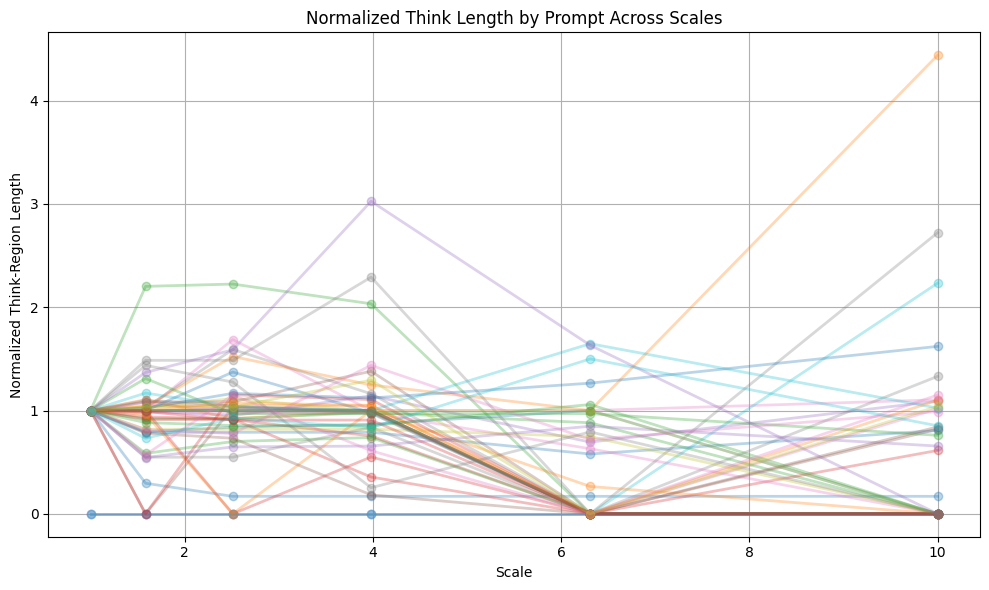

In [53]:
plot_each_prompt_behavior(prompt_patched_generation_dict)


In [56]:
import re
import numpy as np
import matplotlib.pyplot as plt

def analyze_skip_and_reduction(data, model):
    """
    Computes, for each scale:
      1) p_zero: probability of no <think> match (length=0)
      2) relative_zero: p_zero(s) / p_zero(1.0) (or p_zero(s) if baseline zero)
      3) p_reduction: probability that think-length(s) < think-length(1.0)
    
    Parameters:
        data (dict): Mapping (prompt, scale) -> generation string
        model: object with .to_tokens(text) method to tokenize strings
    
    Returns:
        scales (list): sorted list of scales
        p_zero (dict): scale -> probability of zero-length think region
        relative_zero (dict): scale -> relative p_zero vs scale=1.0
        p_reduction (dict): scale -> probability length < baseline
    """
    # 1) Extract think-region lengths
    think_lengths = {}

    for (prompt, scale), gen in data.items():
        matches = re.findall(r"<think>(.*?)</think>", gen, re.DOTALL)
        if matches:
            longest_think = max(matches, key=lambda x: len(x))
            token_len = len(model.to_tokens(longest_think)[0])
        else:
            token_len = 0

        think_lengths.setdefault(prompt, {})[scale] = token_len
    
    prompts = list(think_lengths.keys())
    scales = sorted({s for scale_dict in think_lengths.values() for s in scale_dict})

    # 2) Baseline lengths at scale=1.0
    baseline = {p: think_lengths[p].get(1.0, 0) for p in prompts}

    # 3) Compute probabilities
    p_zero = {}
    p_reduction = {}
    for s in scales:
        zero_count = sum(1 for p in prompts if think_lengths[p].get(s, 0) == 0)
        less_count = sum(1 for p in prompts if think_lengths[p].get(s, 0) < baseline[p])
        N = len(prompts)
        p_zero[s] = zero_count / N
        p_reduction[s] = less_count / N

    # 4) Relative zero probability
    p0_baseline = p_zero.get(1.0, 0)
    relative_zero = {}
    for s in scales:
        if p0_baseline > 0:
            relative_zero[s] = p_zero[s] / p0_baseline
        else:
            relative_zero[s] = p_zero[s]

    return scales, p_zero, relative_zero, p_reduction

def plot_skip_and_reduction(data, model):
    """
    Plots:
      - Relative zero-match probability vs scale
      - Probability of reduced think-length vs scale
    """
    scales, p_zero, relative_zero, p_reduction = analyze_skip_and_reduction(data, model)
    
    rel_vals = [p_zero[s] for s in scales]
    red_vals = [p_reduction[s] for s in scales]
    
    plt.figure(figsize=(8, 5))
    plt.plot(scales, rel_vals, marker='o', label='Zero think Probability')
    plt.plot(scales, red_vals, marker='s', label='Prob. Length < scale=1')
    plt.xlabel("Scale")
    plt.ylabel("Probability")
    plt.title("Skip vs. Reduction Probabilities Across Scales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.show()

# Usage:
# scales, p_zero, relative_zero, p_reduction = analyze_skip_and_reduction(prompt_patched_generation_dict, model)
# plot_skip_and_reduction(prompt_patched_generation_dict, model)


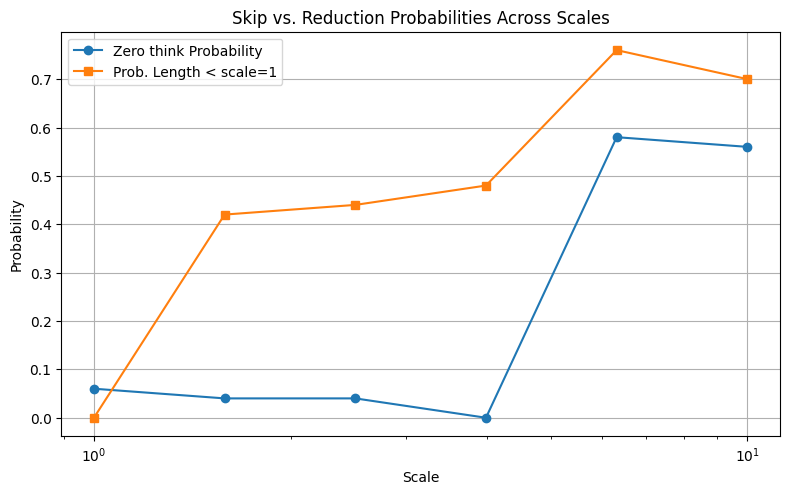

In [57]:
scales, p_zero, rel_zero, p_reduct = analyze_skip_and_reduction(prompt_patched_generation_dict, model)
plot_skip_and_reduction(prompt_patched_generation_dict, model)

In [25]:
prompt_patched_generation_dict

{('What is the square root of 144?',
  np.float64(1.0)): "<｜User｜>What is the square root of 144?<｜Assistant｜><think>\nTo find the square root of 144, I need to determine which number multiplied by itself equals 144.\n\nI'll start by testing smaller numbers and work my way up. \n\nWhen I try 12, multiplying it by itself gives me 144, which matches the target number.\n\nTherefore, the square root of 144 is 12.\n</think>\n\nTo find the square root of **144**, follow these steps:\n\n1. **Understand the Problem:**\n   \n   We need to find a number that, when multiplied by itself, equals **144**. This number is called the square root of **144**.\n\n2. **Calculate the Square Root:**\n   \n   Let's denote the square root of **144** as \\( \\sqrt{144} \\).\n\n3. **Find the Number:**\n   \n   We know that:\n   \\[\n   \\sqrt{144} = 12 \\quad \\text{because} \\quad 12 \\times 12 = 144\n   \\]\n\n4. **Final Answer:**\n   \n   \\[\n   \\boxed{12}\n   \\]",
 ('What is the square root of 144?',
  np

In [58]:
generations = []

for p, f in prompt_patched_generation_dict:
    if p=='What is (7 + 3) × (8 - 5)?':
        generations.append((f, prompt_patched_generation_dict[(p, f)]))

generations.sort() 


for f, p in generations:
    print(f"scale = {f}\n","\n==============================\n", "GENERATION:\n\n", p)

scale = 1.0
 
 GENERATION:

 <｜User｜>What is (7 + 3) × (8 - 5)?<｜Assistant｜><think>
To solve the expression (7 + 3) × (8 - 5), I will first perform the addition inside the first parentheses.

7 plus 3 equals 10.

Next, I will perform the subtraction inside the second parentheses.

8 minus 5 equals 3.

Now, the expression simplifies to 10 multiplied by 3.

Finally, multiplying 10 by 3 gives me 30.
</think>

**Solution:**

We need to evaluate the expression \((7 + 3) \times (8 - 5)\).

1. **Perform the addition inside the first parentheses:**
   \[
   7 + 3 = 10
   \]

2. **Perform the subtraction inside the second parentheses:**
   \[
   8 - 5 = 3
   \]

3. **Multiply the results of the two parentheses:**
   \[
   10 \times 3 = 30
   \]

**Final Answer:**
\[
\boxed{30}
\]
scale = 1.5848931924611136
 
 GENERATION:

 <｜User｜>What is (7 + 3) × (8 - 5)?<｜Assistant｜><think>
To solve the expression \((7 + 3) \times (8 - 5)\), follow these steps:

1. **Add the numbers inside the first parenthe